In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/accepted-loans/elite_data.csv


# Importing libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV, train_test_split, RepeatedStratifiedKFold, learning_curve
from sklearn.metrics import classification_report, fbeta_score, confusion_matrix, precision_recall_curve, auc, make_scorer

# Reading data

In [3]:
accepted_loans = pd.read_csv('/kaggle/input/accepted-loans/elite_data.csv')

In [4]:
accepted_loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1343380 entries, 0 to 1343379
Data columns (total 78 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   loan_amnt                            1343380 non-null  float64
 1   term                                 1343380 non-null  int64  
 2   int_rate                             1343380 non-null  float64
 3   installment                          1343380 non-null  float64
 4   annual_inc                           1343380 non-null  float64
 5   dti                                  1343380 non-null  float64
 6   delinq_2yrs                          1343380 non-null  float64
 7   fico_range_high                      1343380 non-null  float64
 8   inq_last_6mths                       1343380 non-null  float64
 9   open_acc                             1343380 non-null  float64
 10  pub_rec                              1343380 non-null  float64
 11

In [5]:
accepted_loans.shape

(1343380, 78)

In [6]:
accepted_loans.head()

,loan_amnt,term,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,...,purpose_small_business,purpose_vacation,purpose_wedding,application_type_Joint App,initial_list_status_w,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
0,3600.0,36,13.99,123.03,55000.0,5.91,0.0,679.0,1.0,7.0,...,0,0,0,0,1,1,0,0,0,0
1,24700.0,36,11.99,820.28,65000.0,16.06,1.0,719.0,4.0,22.0,...,1,0,0,0,1,1,0,0,0,0
2,20000.0,60,10.78,432.66,63000.0,10.78,0.0,699.0,0.0,6.0,...,0,0,0,1,1,1,0,0,0,0
3,10400.0,60,22.45,289.91,104433.0,25.37,1.0,699.0,3.0,12.0,...,0,0,0,0,1,1,0,0,0,0
4,11950.0,36,13.44,405.18,34000.0,10.20,0.0,694.0,0.0,5.0,...,0,0,0,0,1,0,0,0,0,1


<Axes: xlabel='loan_paid', ylabel='count'>

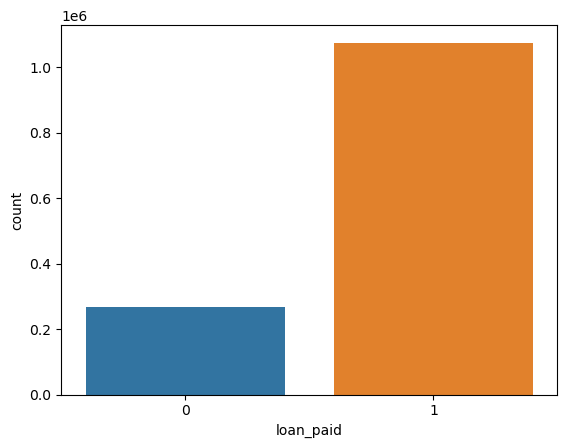

In [7]:
sns.countplot(x=accepted_loans['loan_paid'], data=accepted_loans)

In [8]:
num_fully_paid_loans = accepted_loans[accepted_loans['loan_paid'] == 1.0].shape[0]
num_charged_off_loans = accepted_loans[accepted_loans['loan_paid'] == 0.0].shape[0]
print("The number of Fully Paid loans: ", num_fully_paid_loans)
print("The number of Default loans: ", num_charged_off_loans)
print("Fully Paid / Default Ratio: ", num_fully_paid_loans / num_charged_off_loans)

The number of Fully Paid loans:  1075191
The number of Default loans:  268189
Fully Paid / Default Ratio:  4.009079417873216


# Data processing

# Preparing parameters

**Features and labels**

In [9]:
X = accepted_loans.loc[:,accepted_loans.columns != 'loan_paid'].values
y = accepted_loans['loan_paid'].values

**Train-Test split**

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state=42, stratify =y)

In [11]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1074704, 77) (1074704,)
(268676, 77) (268676,)


**Param grid for searching**

In [12]:
param_grid = {}

In [13]:
cv = RepeatedStratifiedKFold(n_splits= 5, n_repeats=2, random_state =42)

# Outliers handling

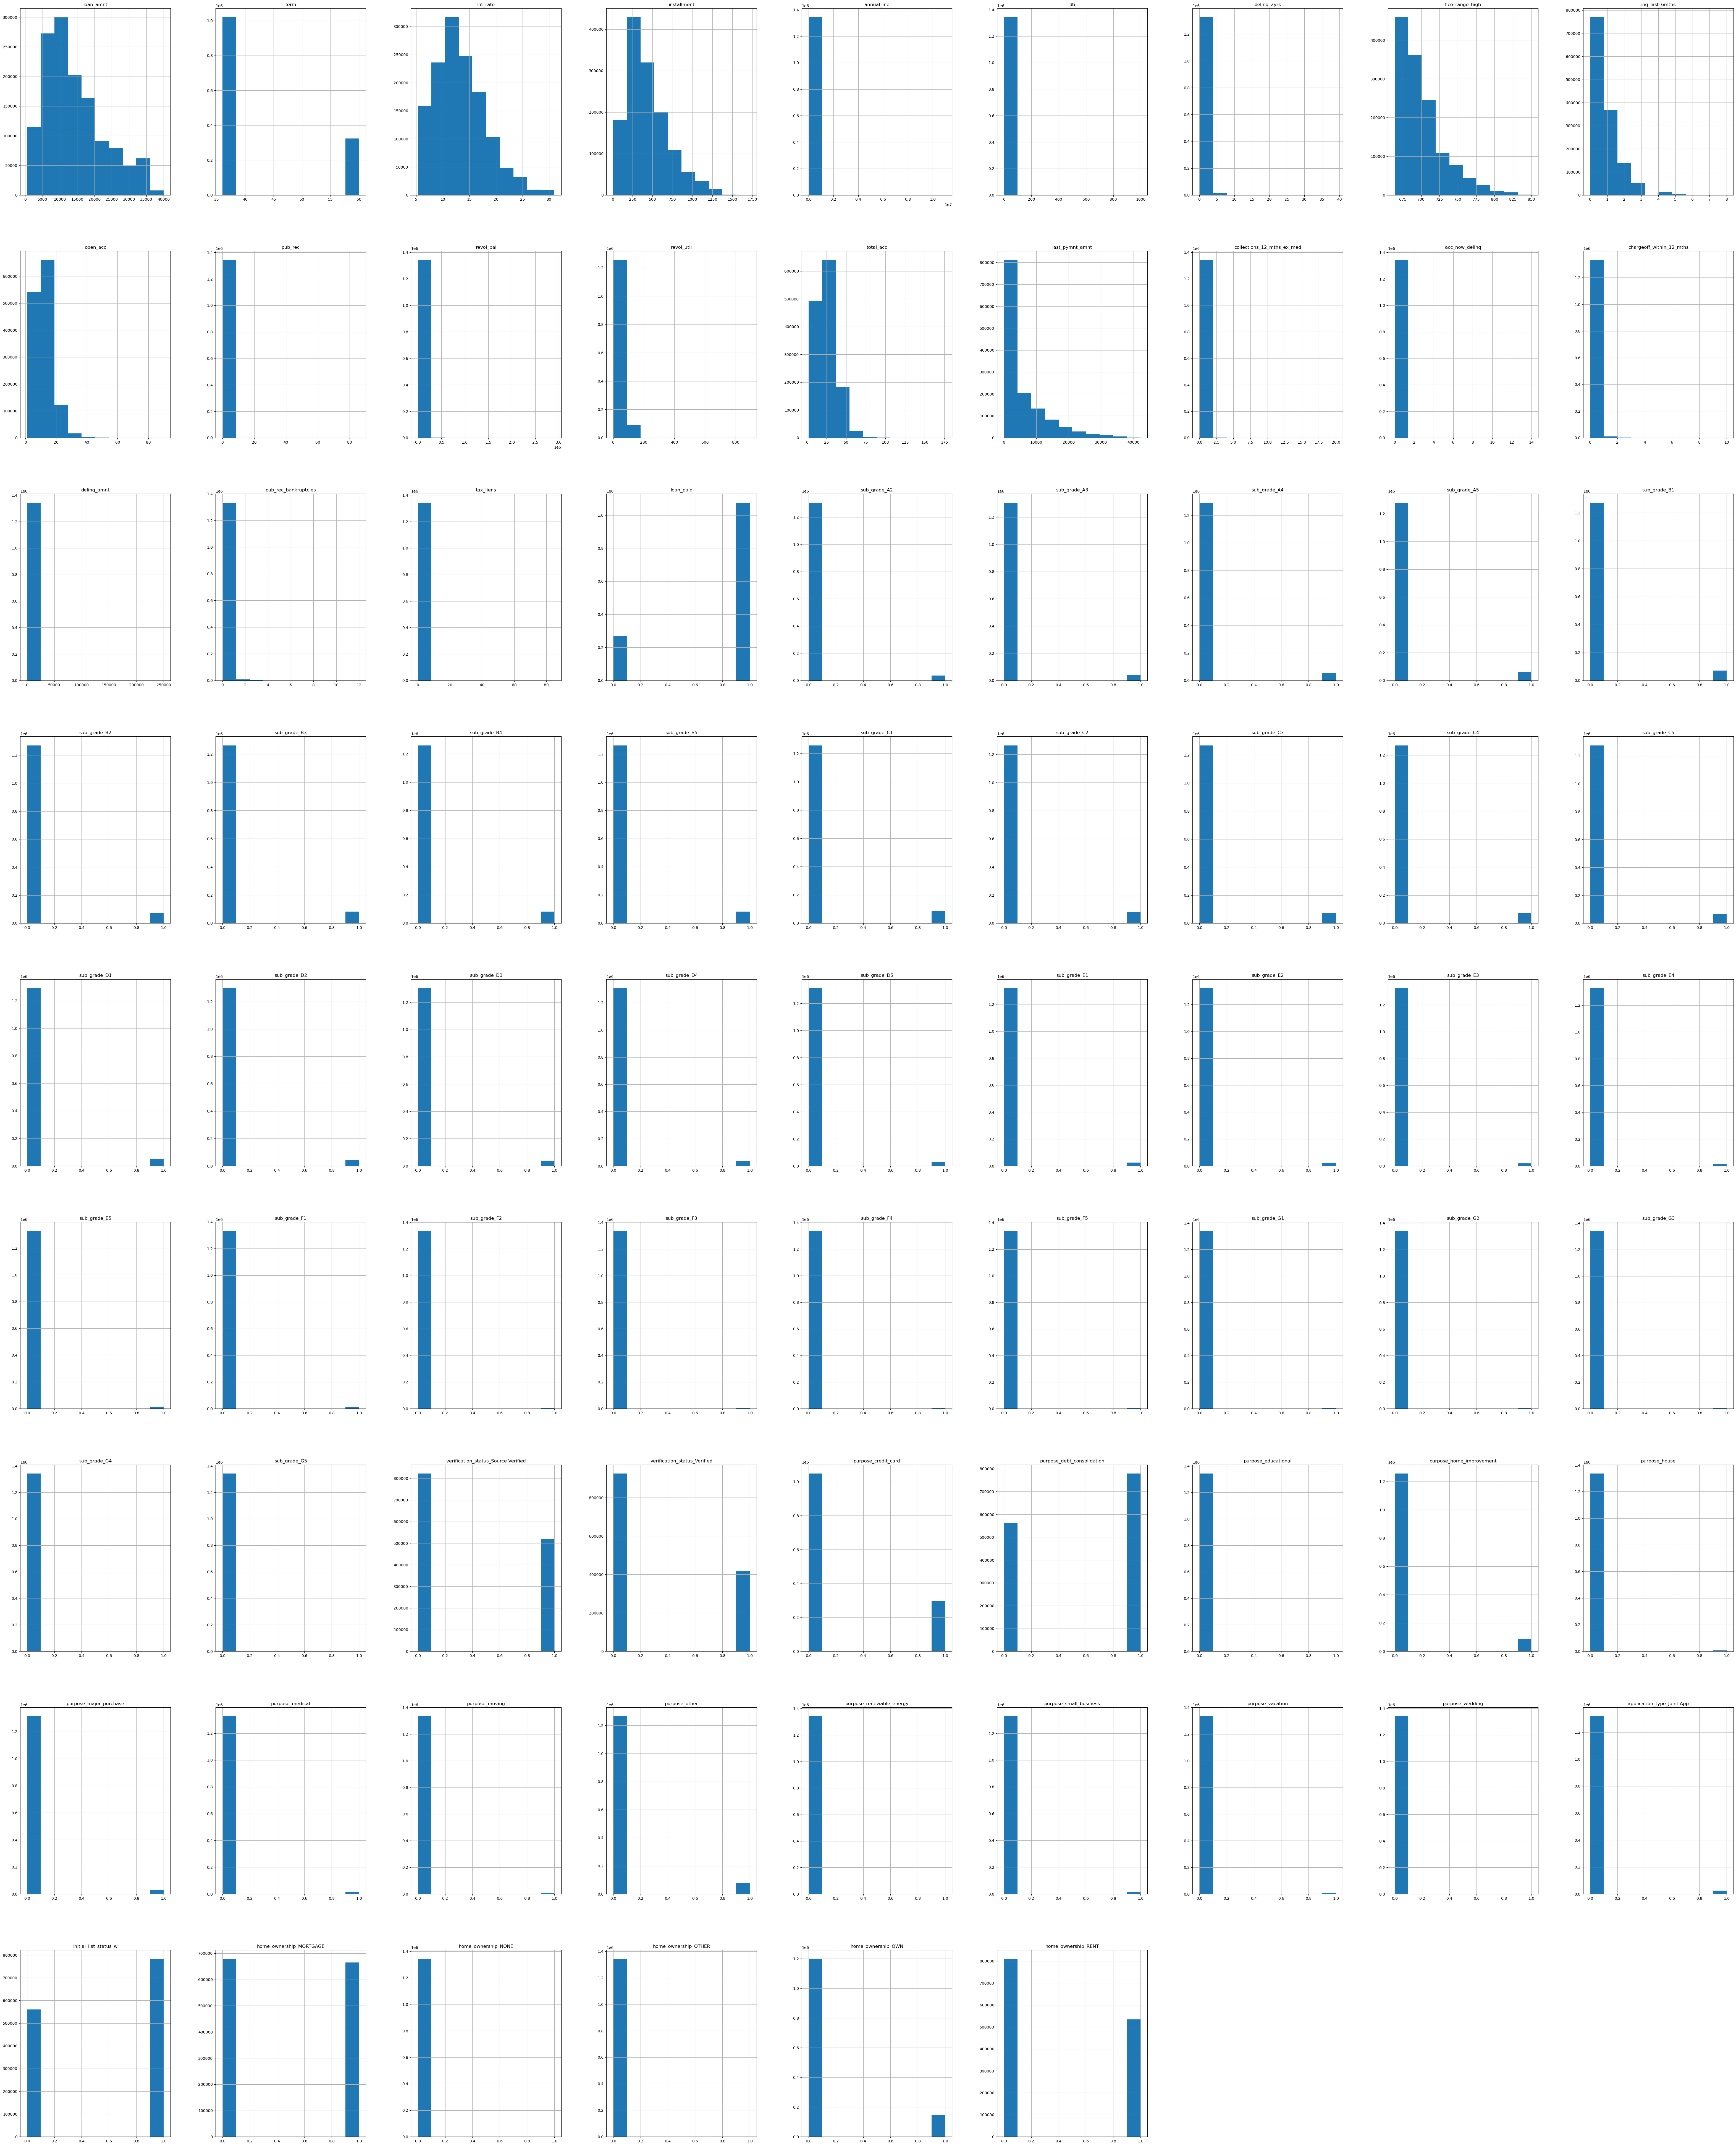

In [14]:
accepted_loans.hist(figsize=(80, 100))
plt.show()

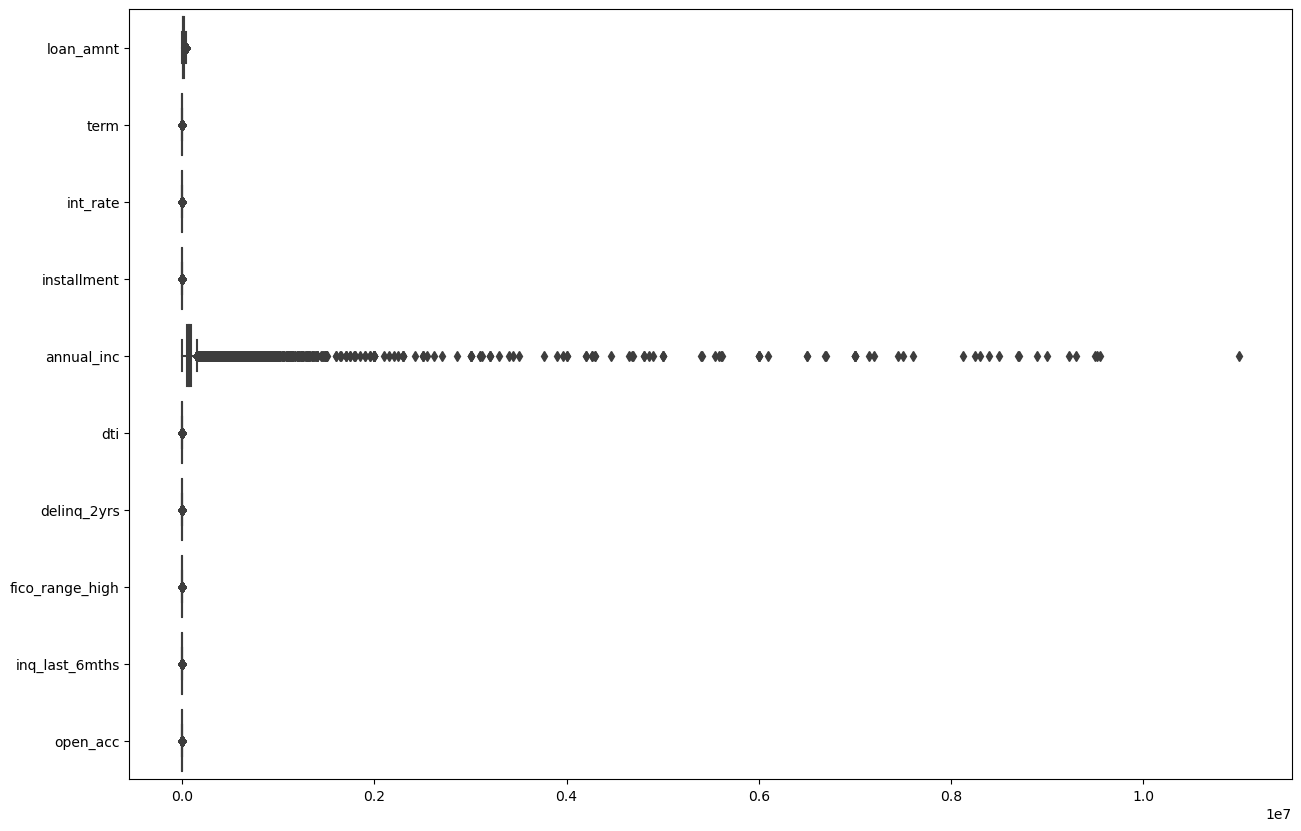

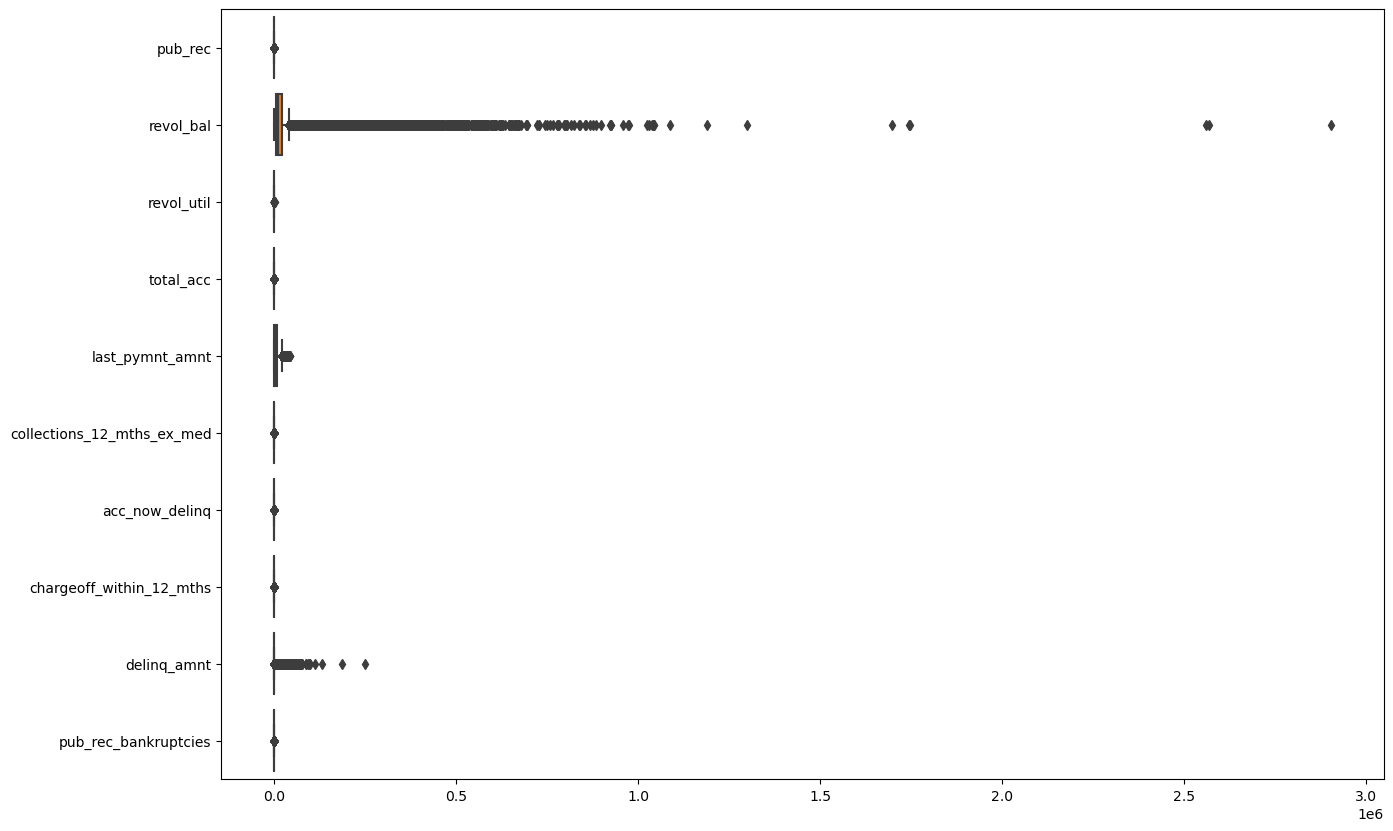

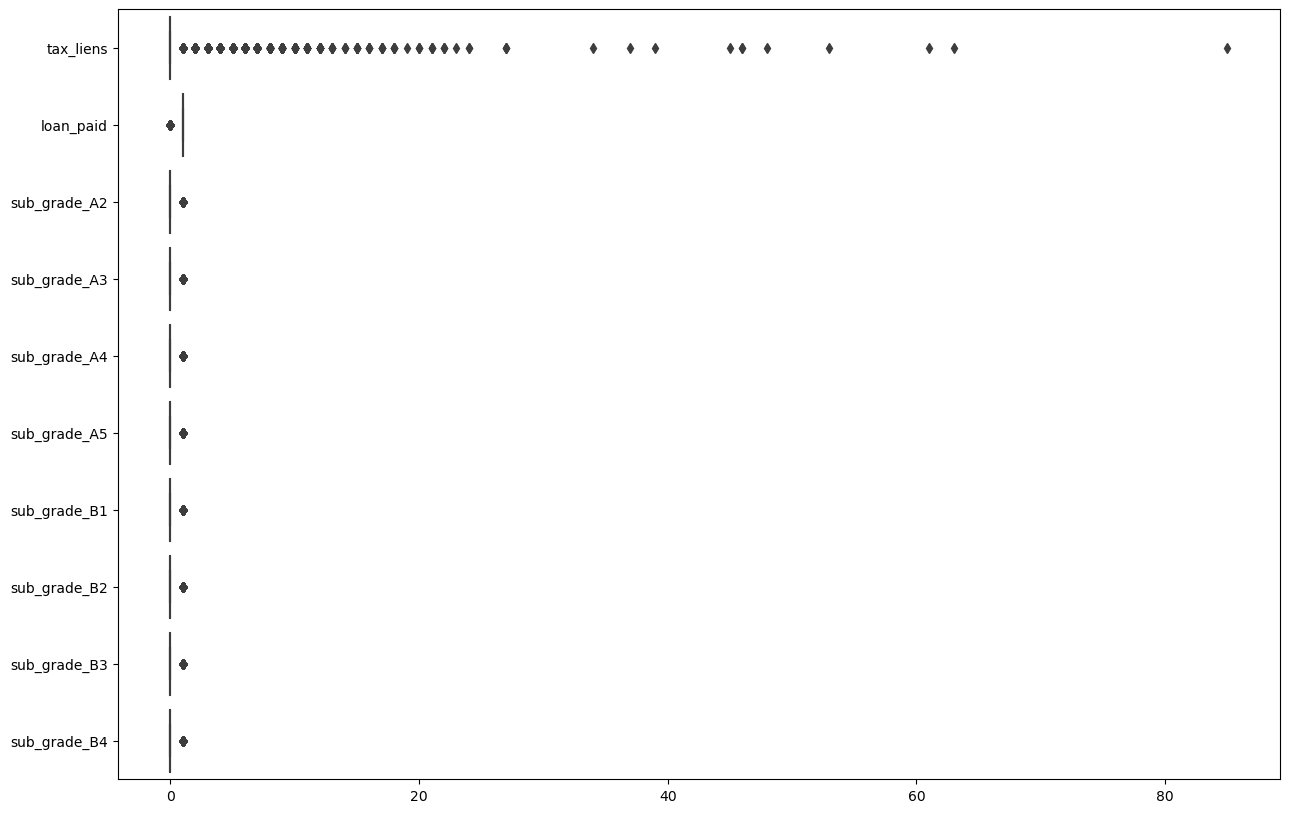

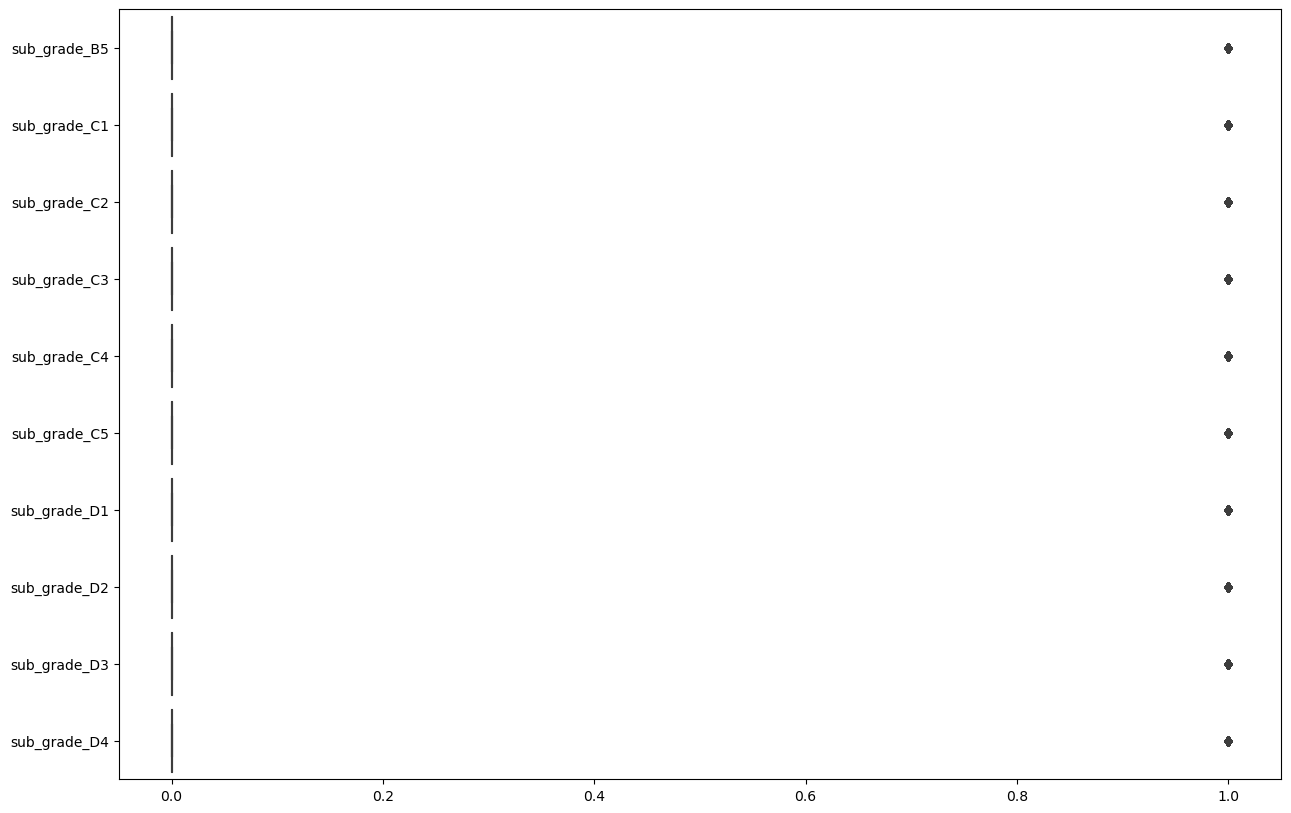

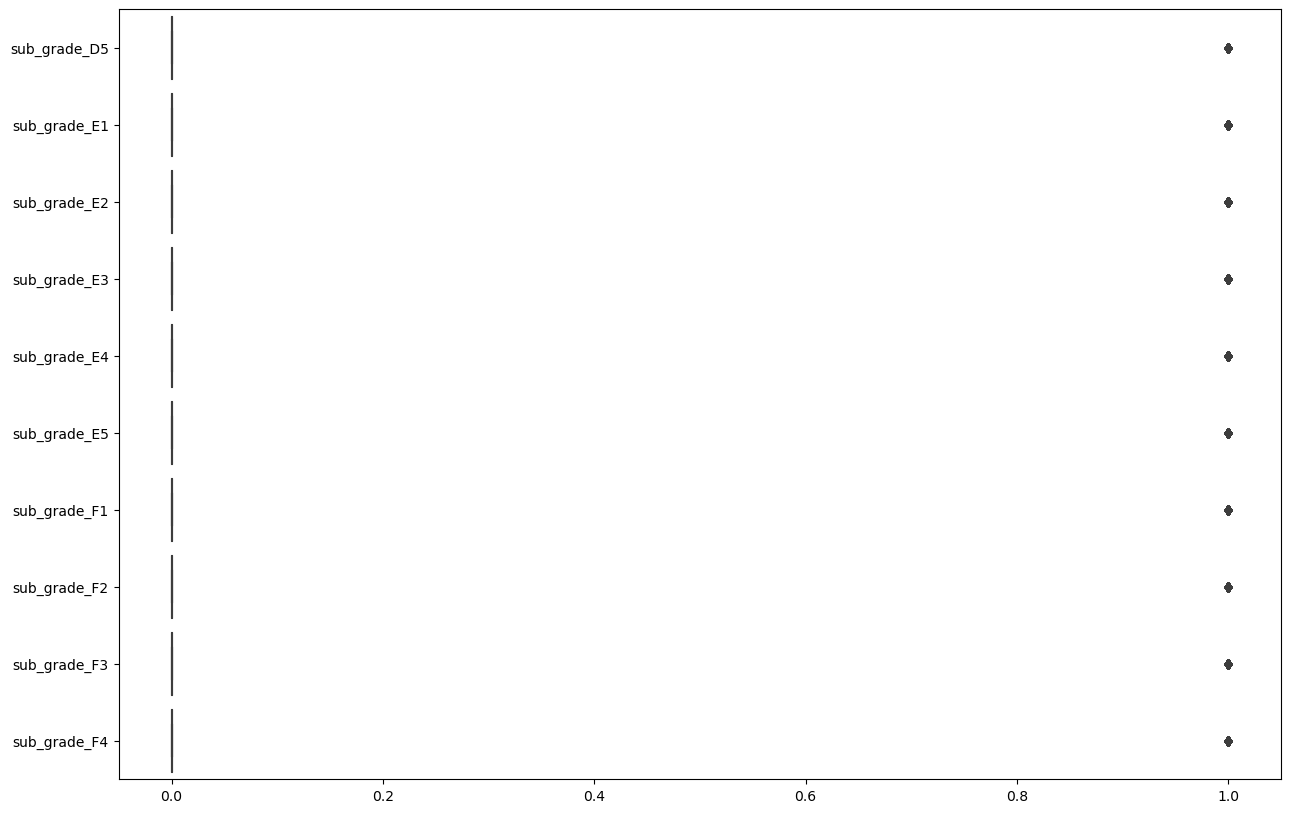

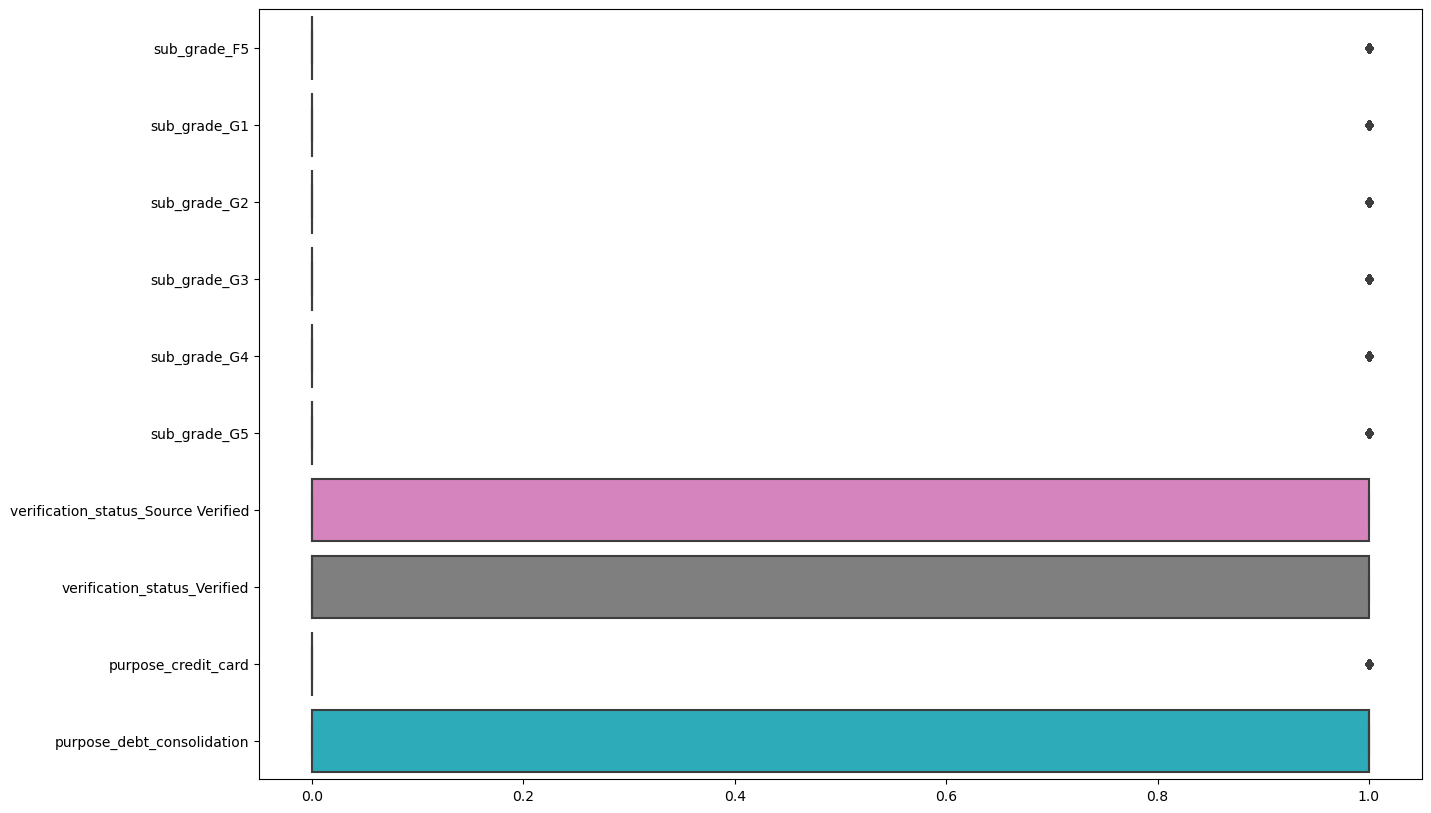

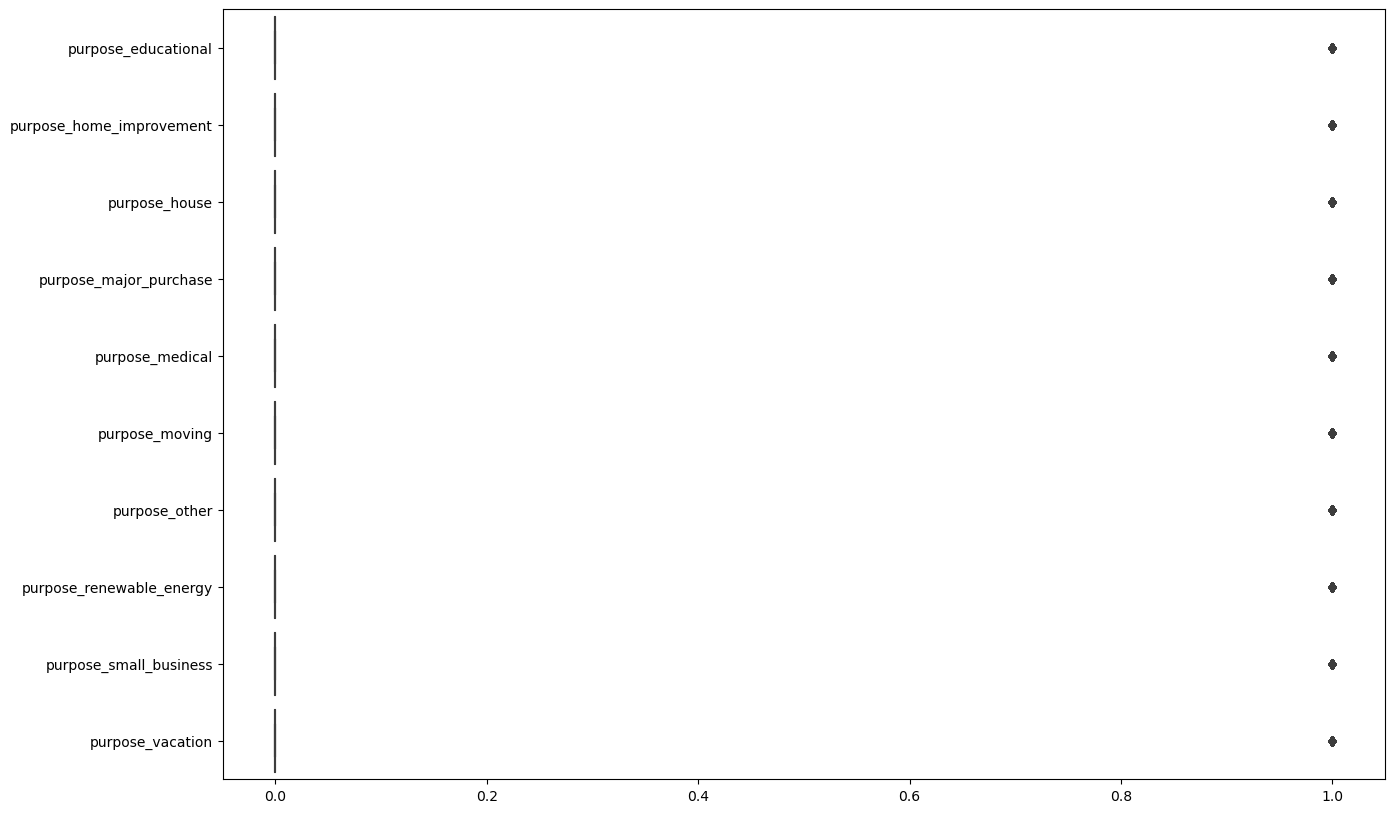

In [15]:
for i in range(0, 70, 10):
    plt.figure(figsize=(15, 10))
    sns.boxplot(data=accepted_loans.iloc[:, i: i + 10], orient='h')
    plt.show()

# Scaler

From plotting the histogram of each input variable, we see that almost variables are located in just 2 bins while others have skewed distribution -> It's better to use MinMaxScaler

In [16]:
minmax_scaler =('minmax', MinMaxScaler())

# Imbalanced data handling

**SMOTE**

In [17]:
smote = ('smote', SMOTE(sampling_strategy=1.0, random_state=42))
smote_param_grid = {
    'smote__sampling_strategy': [0.8, 0.9, 1.0]
}

# Model

In [18]:
lr = ('lr', LogisticRegression())
lr_param_grid = {
    'lr__C': [0.01, 0.1, 1, 10, 100],
    'lr__penalty': ['l2'],
    'lr__max_iter': [100, 500],
    'lr__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

# Training and Evaluation

In [19]:
#Metric
f_onehalf_scorer = make_scorer(fbeta_score, beta=0.5)

In [20]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=cv,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    if axes is None:
        _, axes = plt.subplots(3, 1, figsize=(15, 15))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        scoring=f_onehalf_scorer,
        return_times=True,
        random_state=42
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times") 
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [21]:
def plot_search_results(search):
    df = pd.DataFrame(search.cv_results_)
    results = ['mean_test_score',
            'mean_train_score',
            'std_test_score', 
            'std_train_score']

    fig, axes = plt.subplots(1, len(param_grid), 
                          figsize = (7*len(param_grid), 5),
                          sharey='row')
    if len(param_grid) == 1:
        axes = [axes]

    axes[0].set_ylabel("Score", fontsize=25)


    for idx, (param_name, param_range) in enumerate(param_grid.items()):
      grouped_df = df.groupby(f'param_{param_name}')[results]\
          .agg({'mean_train_score': 'mean',
                'mean_test_score': 'mean',
                'std_train_score': 'mean',
                'std_test_score': 'mean'})

      previous_group = df.groupby(f'param_{param_name}')[results]
      axes[idx].set_xlabel(param_name, fontsize=30)
      axes[idx].set_ylim(0.0, 1.1)
      lw = 2
      axes[idx].plot(param_range, grouped_df['mean_train_score'], label="Training score",
                  color="darkorange", lw=lw)
      axes[idx].fill_between(param_range,grouped_df['mean_train_score'] - grouped_df['std_train_score'],
                      grouped_df['mean_train_score'] + grouped_df['std_train_score'], alpha=0.2,
                      color="darkorange", lw=lw)
      axes[idx].plot(param_range, grouped_df['mean_test_score'], label="Cross-validation score",
                  color="navy", lw=lw)
      axes[idx].fill_between(param_range, grouped_df['mean_test_score'] - grouped_df['std_test_score'],
                      grouped_df['mean_test_score'] + grouped_df['std_test_score'], alpha=0.2,
                      color="navy", lw=lw)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.suptitle('Validation curves', fontsize=40)
    fig.legend(handles, labels, loc=8, ncol=2, fontsize=20)

    fig.subplots_adjust(bottom=0.25, top=0.85)  
    plt.show()

In [22]:
def print_result_df(search):
  keeping_columns = ['params', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score', 'mean_fit_time', 'std_fit_time']
  df = pd.DataFrame(search.cv_results_)
  df = df[keeping_columns].sort_values(by='mean_test_score', ascending=False)
  return df.iloc[:10, :]

In [23]:
def print_best_model_result(search, name):
  print("Best parameter (CV score=):" % search.best_score_)
  best_model = search.best_estimator_
  print(best_model)

  y_pred = best_model.predict(X_test)
  y_score = best_model.predict_proba(X_test)[:, 1]

  print(classification_report(y_test, y_pred))
  print(confusion_matrix(y_test, y_pred))

  # calculate precision and recall for each threshold
  precision, recall, threshold = precision_recall_curve(y_test, y_score)
  # calculate scores
  f_onehalf_score, pr_auc = fbeta_score(y_test, y_pred, beta=0.5), auc(recall, precision)
  print('f0.5_score=', f_onehalf_score)
  print('pr_auc_score=', pr_auc)

  # calculate the no skill line as the proportion of the positive class
  no_skill = len(y_test[y_test==1]) / len(y_test)
  # plot the no skill precision-recall curve
  plt.figure(figsize=(10, 7))
  plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
  # plot the model precision-recall curve
  plt.plot(recall, precision, marker='.', label=name)
  plt.title(f'{name}(pr_auc={pr_auc})')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  # show the legend
  plt.legend()
  # show the plot
  plt.show()

  plot_learning_curve(best_model, name, X_train, y_train, cv=cv, n_jobs=-1 )
  plt.show()

  return best_model, f_onehalf_score, pr_auc

# Logistic Regression

# MinMaxScaler Tuning Logistic Regression

In [24]:
pipe = Pipeline(steps=[minmax_scaler, lr])

In [25]:
param_grid = lr_param_grid

In [26]:
search = HalvingGridSearchCV(pipe, param_grid, scoring=f_onehalf_scorer, cv=cv, verbose=3, return_train_score=True)

In [27]:
search.fit(X_train, y_train)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 39803
max_resources_: 1074704
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 50
n_resources: 39803
Fitting 10 folds for each of 50 candidates, totalling 500 fits
[CV 1/10] END lr__C=0.01, lr__max_iter=100, lr__penalty=l2, lr__solver=newton-cg;, score=(train=0.861, test=0.860) total time=   0.7s
[CV 2/10] END lr__C=0.01, lr__max_iter=100, lr__penalty=l2, lr__solver=newton-cg;, score=(train=0.864, test=0.866) total time=   0.7s
[CV 3/10] END lr__C=0.01, lr__max_iter=100, lr__penalty=l2, lr__solver=newton-cg;, score=(train=0.865, test=0.864) total time=   0.7s
[CV 4/10] END lr__C=0.01, lr__max_iter=100, lr__penalty=l2, lr__solver=newton-cg;, score=(train=0.861, test=0.862) total time=   0.7s
[CV 5/10] END lr__C=0.01, lr__max_iter=100, lr__penalty=l2, lr__solver=newton-cg;, score=(train=0.867, test=0.863) total time=   0.7s
[CV 6/10] END lr__C=0.01, lr__max_iter=100, lr__penalty=l2, 

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.897, test=0.896) total time=   0.7s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.899, test=0.904) total time=   0.7s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.900, test=0.900) total time=   0.8s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.898, test=0.901) total time=   0.7s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.901, test=0.891) total time=   0.8s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 6/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.902, test=0.894) total time=   0.7s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 7/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.900, test=0.900) total time=   0.7s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 8/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.897, test=0.902) total time=   0.7s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 9/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.899, test=0.902) total time=   0.7s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 10/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.899, test=0.898) total time=   0.7s
[CV 1/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.897, test=0.896) total time=   0.6s
[CV 2/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.899, test=0.904) total time=   0.6s
[CV 3/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.900, test=0.900) total time=   0.6s
[CV 4/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.898, test=0.901) total time=   0.6s
[CV 5/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.901, test=0.891) total time=   0.6s
[CV 6/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.903, test=0.894) total time=   0.6s
[CV 7/10] END lr__C=1, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.902, test=0.900) total time=   0.9s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.904, test=0.908) total time=   0.8s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.905, test=0.905) total time=   0.7s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.903, test=0.906) total time=   0.8s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.906, test=0.896) total time=   0.7s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 6/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.906, test=0.897) total time=   0.7s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 7/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.905, test=0.905) total time=   0.7s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 8/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.902, test=0.907) total time=   0.8s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 9/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.904, test=0.905) total time=   0.8s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 10/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.904, test=0.901) total time=   0.7s
[CV 1/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.901, test=0.900) total time=   1.0s
[CV 2/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.904, test=0.908) total time=   0.7s
[CV 3/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.905, test=0.904) total time=   0.7s
[CV 4/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.902, test=0.906) total time=   1.0s
[CV 5/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.906, test=0.896) total time=   0.8s
[CV 6/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.906, test=0.897) total time=   0.8s
[CV 7/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 8/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.902, test=0.907) total time=   5.7s
[CV 9/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.904, test=0.905) total time=   3.7s
[CV 10/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.904, test=0.901) total time=   2.8s
[CV 1/10] END lr__C=10, lr__max_iter=500, lr__penalty=l2, lr__solver=newton-cg;, score=(train=0.901, test=0.900) total time=   2.6s
[CV 2/10] END lr__C=10, lr__max_iter=500, lr__penalty=l2, lr__solver=newton-cg;, score=(train=0.904, test=0.908) total time=   2.5s
[CV 3/10] END lr__C=10, lr__max_iter=500, lr__penalty=l2, lr__solver=newton-cg;, score=(train=0.905, test=0.904) total time=   2.9s
[CV 4/10] END lr__C=10, lr__max_iter=500, lr__penalty=l2, lr__solver=newton-cg;, score=(train=0.902, test=0.906) total time=   2.2s
[CV 5/10] END lr__C=10, lr__max_iter=500, lr__penalty=l2, lr__solver=newton-cg;, score=(tr

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.903, test=0.902) total time=   0.7s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.905, test=0.909) total time=   0.9s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.906, test=0.906) total time=   0.7s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.904, test=0.907) total time=   0.8s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.907, test=0.897) total time=   0.7s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 6/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.907, test=0.897) total time=   0.8s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 7/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.905, test=0.905) total time=   0.8s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 8/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.903, test=0.909) total time=   0.8s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 9/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.904, test=0.906) total time=   0.8s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 10/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.904, test=0.902) total time=   0.8s
[CV 1/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.903, test=0.901) total time=   1.2s
[CV 2/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.905, test=0.909) total time=   1.1s
[CV 3/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.906, test=0.904) total time=   1.1s
[CV 4/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.903, test=0.906) total time=   1.1s
[CV 5/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.908, test=0.898) total time=   1.1s
[CV 6/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.907, test=0.898) total time=   1.1s
[CV 7/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=li

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.904, test=0.906) total time=   5.9s
[CV 5/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.908, test=0.898) total time=   3.6s
[CV 6/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.907, test=0.898) total time=   4.7s
[CV 7/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.907, test=0.906) total time=   5.7s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 8/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.903, test=0.908) total time=   5.8s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 9/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.904, test=0.906) total time=   5.8s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 10/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.904, test=0.902) total time=   5.9s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.903, test=0.901) total time=   6.0s
[CV 2/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.905, test=0.909) total time=   4.8s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.906, test=0.904) total time=   6.0s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.904, test=0.906) total time=   6.0s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.908, test=0.898) total time=   6.0s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 6/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.907, test=0.898) total time=   6.0s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 7/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.907, test=0.906) total time=   6.0s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 8/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.903, test=0.908) total time=   6.0s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 9/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.904, test=0.906) total time=   6.0s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 10/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.904, test=0.902) total time=   6.0s
[CV 1/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=newton-cg;, score=(train=0.903, test=0.901) total time=   4.7s
[CV 2/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=newton-cg;, score=(train=0.905, test=0.909) total time=   3.3s
[CV 3/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=newton-cg;, score=(train=0.906, test=0.904) total time=   3.6s
[CV 4/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=newton-cg;, score=(train=0.903, test=0.906) total time=   3.3s
[CV 5/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=newton-cg;, score=(train=0.908, test=0.898) total time=   4.0s
[CV 6/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=newton-cg;, score=(train=0.907, test=0.898) total time=   3.1s
[CV 7/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=new

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.903, test=0.901) total time=   3.4s
[CV 2/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.905, test=0.909) total time=   2.6s
[CV 3/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.906, test=0.904) total time=   2.9s
[CV 4/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.903, test=0.906) total time=   3.2s
[CV 5/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.908, test=0.898) total time=   2.8s
[CV 6/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.907, test=0.898) total time=   2.5s
[CV 7/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.907, test=0.906) total time=   3.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 8/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.903, test=0.908) total time=   3.4s
[CV 9/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.904, test=0.906) total time=   3.0s
[CV 10/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.904, test=0.902) total time=   2.9s
[CV 1/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.903, test=0.901) total time=   1.1s
[CV 2/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.905, test=0.909) total time=   1.1s
[CV 3/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.906, test=0.904) total time=   1.1s
[CV 4/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.903, test=0.906) total time=   1.1s
[CV 5/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=liblinear;

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.902, test=0.902) total time=   2.4s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.903, test=0.908) total time=   2.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.904, test=0.903) total time=   2.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.904, test=0.902) total time=   2.1s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.905, test=0.900) total time=   2.3s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 6/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.903, test=0.904) total time=   2.8s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 7/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.903, test=0.904) total time=   2.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 8/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.903, test=0.907) total time=   2.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 9/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.904, test=0.902) total time=   2.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 10/10] END lr__C=10, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.904, test=0.903) total time=   2.1s
[CV 1/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.903, test=0.902) total time=   8.2s
[CV 2/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.903, test=0.909) total time=  11.7s
[CV 3/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.904, test=0.903) total time=  17.8s
[CV 4/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.905, test=0.902) total time=  29.2s
[CV 5/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.906, test=0.901) total time=  18.2s
[CV 6/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.904, test=0.905) total time=  17.9s
[CV 7/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=sag;, score=(train=0.904, test=0.905) t

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.904, test=0.903) total time=  11.0s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.905, test=0.902) total time=  10.0s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.906, test=0.901) total time=  10.2s
[CV 6/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.904, test=0.905) total time=  10.8s
[CV 7/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.904, test=0.905) total time=   7.5s
[CV 8/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.904, test=0.907) total time=   9.3s
[CV 9/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.904, test=0.902) total time=  10.9s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 10/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.905, test=0.904) total time=  10.3s
[CV 1/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=saga;, score=(train=0.903, test=0.902) total time=  11.5s
[CV 2/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=saga;, score=(train=0.903, test=0.909) total time=  13.2s
[CV 3/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=saga;, score=(train=0.904, test=0.903) total time=  26.1s
[CV 4/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=saga;, score=(train=0.905, test=0.902) total time=  38.2s
[CV 5/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=saga;, score=(train=0.906, test=0.901) total time=  23.9s
[CV 6/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=saga;, score=(train=0.904, test=0.905) total time=  18.1s
[CV 7/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=saga;, score=(train=0.904, test=

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.904, test=0.903) total time=  17.6s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.905, test=0.902) total time=  17.6s
[CV 5/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.906, test=0.901) total time=  17.5s
[CV 6/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.904, test=0.905) total time=  15.5s
[CV 7/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.904, test=0.904) total time=   5.4s
[CV 8/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.904, test=0.907) total time=  13.5s
[CV 9/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.904, test=0.902) total time=  15.5s
[CV 10/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=sag;, score=(train=0.905, test=0.904) total time=  13.6s
[CV 1/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=newton-cg;, score=(train=0.903, test=0.9

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.904, test=0.903) total time=  17.9s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.905, test=0.902) total time=  17.9s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.906, test=0.901) total time=  17.9s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 6/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.904, test=0.905) total time=  18.0s
[CV 7/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.904, test=0.905) total time=  10.5s
[CV 8/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.904, test=0.907) total time=  14.8s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 9/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.904, test=0.902) total time=  17.7s
[CV 10/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.905, test=0.904) total time=  15.9s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.903, test=0.902) total time=   2.1s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.903, test=0.909) total time=   2.4s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.904, test=0.903) total time=   2.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.905, test=0.902) total time=   2.1s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.906, test=0.901) total time=   2.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 6/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.904, test=0.904) total time=   2.1s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 7/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.904, test=0.904) total time=   2.3s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 8/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.903, test=0.908) total time=   2.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 9/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.904, test=0.902) total time=   2.3s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 10/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.904, test=0.903) total time=   2.1s
----------
iter: 2
n_candidates: 6
n_resources: 358227
Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV 1/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.904, test=0.906) total time=  14.1s
[CV 2/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.904, test=0.905) total time=  12.6s
[CV 3/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.903, test=0.904) total time=  12.5s
[CV 4/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.905, test=0.903) total time=  12.9s
[CV 5/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(train=0.904, test=0.903) total time=  14.1s
[CV 6/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=liblinear;, score=(

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.904, test=0.903) total time=  56.5s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 6/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.904, test=0.904) total time=  56.3s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 7/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.904, test=0.905) total time=  56.0s
[CV 8/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.904, test=0.905) total time=  43.2s
[CV 9/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.905, test=0.905) total time=  23.3s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 10/10] END lr__C=100, lr__max_iter=100, lr__penalty=l2, lr__solver=saga;, score=(train=0.903, test=0.903) total time=  56.1s
[CV 1/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.904, test=0.906) total time=  30.9s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.904, test=0.905) total time=  32.6s
[CV 3/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.903, test=0.904) total time=  30.3s
[CV 4/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.905, test=0.903) total time=  28.9s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.904, test=0.903) total time=  33.9s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 6/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.904, test=0.904) total time=  32.7s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 7/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.904, test=0.905) total time=  31.4s
[CV 8/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.904, test=0.905) total time=  26.1s
[CV 9/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.905, test=0.905) total time=  28.5s
[CV 10/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=lbfgs;, score=(train=0.903, test=0.903) total time=  28.7s
----------
iter: 3
n_candidates: 2
n_resources: 1074681
Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV 1/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=newton-cg;, score=(train=0.904, test=0.904) total time= 2.0min
[CV 2/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=newton-cg;, score=(train=0.904, test=0.904) total time= 2.6min
[CV 3/10] END lr__C=100, lr__max_iter=500, lr__penalty=l2, lr__solver=newton-cg;, score=(train=0.904

HalvingGridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=42),
                    estimator=Pipeline(steps=[('minmax', MinMaxScaler()),
                                              ('lr', LogisticRegression())]),
                    param_grid={'lr__C': [0.01, 0.1, 1, 10, 100],
                                'lr__max_iter': [100, 500],
                                'lr__penalty': ['l2'],
                                'lr__solver': ['newton-cg', 'lbfgs',
                                               'liblinear', 'sag', 'saga']},
                    scoring=make_scorer(fbeta_score, beta=0.5), verbose=3)

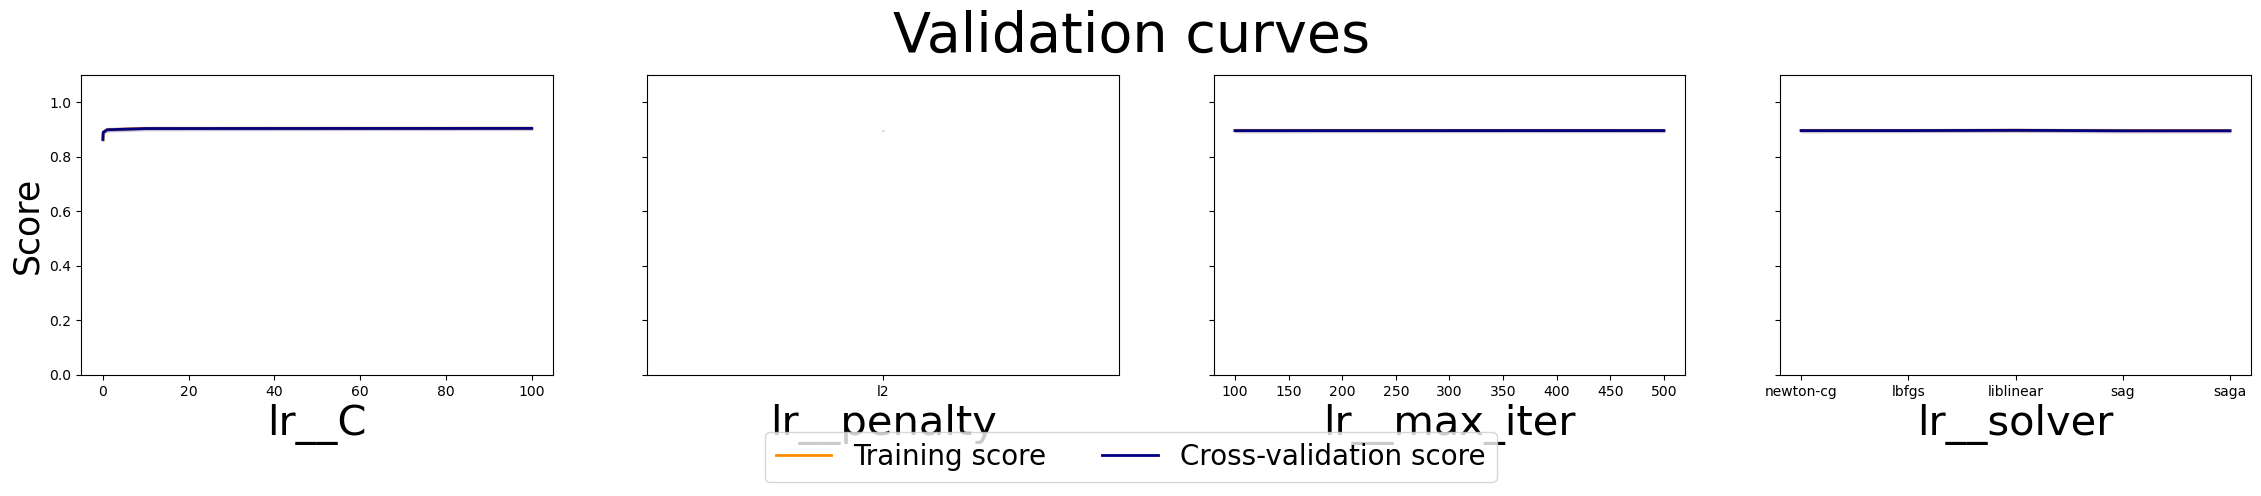

In [28]:
# Plot effect of each param when fixing other params at its best value in pipeline
plot_search_results(search)

In [29]:
print_result_df(search)

,params,mean_train_score,std_train_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time
71,"{'lr__C': 100, 'lr__max_iter': 100, 'lr__penal...",0.904020,0.000454,0.904211,0.001057,42.898820,12.784984
70,"{'lr__C': 100, 'lr__max_iter': 500, 'lr__penal...",0.904020,0.000460,0.904210,0.001051,47.883019,4.784997
69,"{'lr__C': 100, 'lr__max_iter': 100, 'lr__penal...",0.904020,0.000460,0.904210,0.001051,47.173949,4.952339
72,"{'lr__C': 100, 'lr__max_iter': 500, 'lr__penal...",0.904026,0.000462,0.904209,0.001037,30.287171,2.243304
68,"{'lr__C': 100, 'lr__max_iter': 500, 'lr__penal...",0.904014,0.000454,0.904204,0.001041,13.408857,0.713750
67,"{'lr__C': 100, 'lr__max_iter': 100, 'lr__penal...",0.904014,0.000454,0.904204,0.001041,13.283113,0.690454
58,"{'lr__C': 100, 'lr__max_iter': 500, 'lr__penal...",0.904218,0.000866,0.903969,0.002518,9.870467,1.014129
65,"{'lr__C': 100, 'lr__max_iter': 100, 'lr__penal...",0.904226,0.000866,0.903962,0.002502,15.588813,2.715397
73,"{'lr__C': 100, 'lr__max_iter': 500, 'lr__penal...",0.904022,0.000109,0.903961,0.000561,138.248221,16.668730
74,"{'lr__C': 100, 'lr__max_iter': 100, 'lr__penal...",0.904023,0.000110,0.903959,0.000561,61.806286,19.364617


Best parameter (CV score=):
Pipeline(steps=[('minmax', MinMaxScaler()),
                ('lr',
                 LogisticRegression(C=100, max_iter=500, solver='newton-cg'))])
              precision    recall  f1-score   support

           0       0.71      0.55      0.62     53638
           1       0.89      0.95      0.92    215038

    accuracy                           0.87    268676
   macro avg       0.80      0.75      0.77    268676
weighted avg       0.86      0.87      0.86    268676

[[ 29476  24162]
 [ 11773 203265]]
f0.5_score= 0.9036040137062057
pr_auc_score= 0.9817869448466835


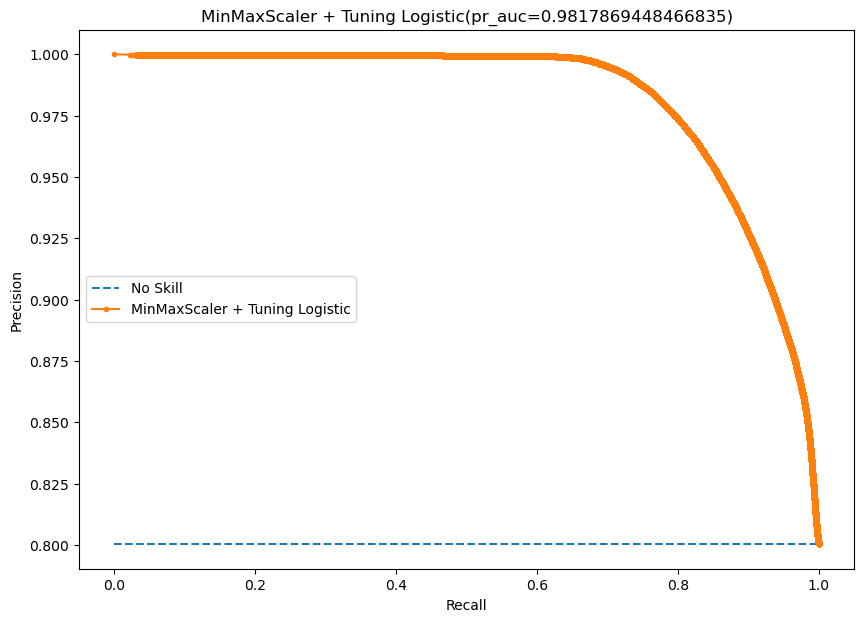

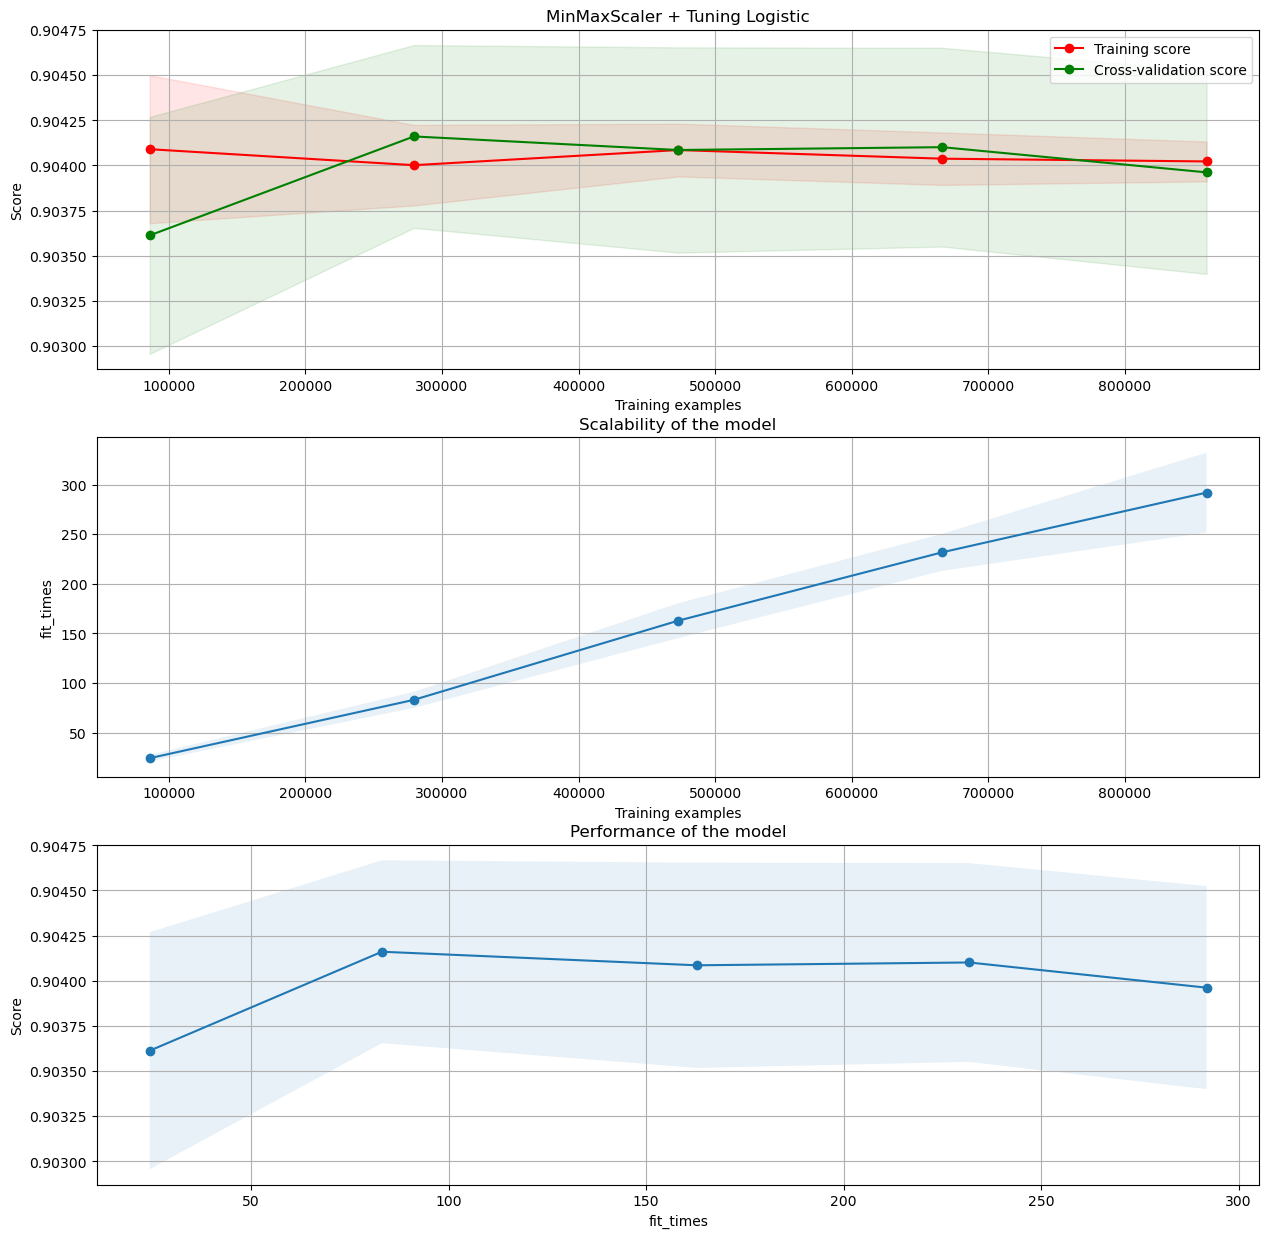

(Pipeline(steps=[('minmax', MinMaxScaler()),
                 ('lr',
                  LogisticRegression(C=100, max_iter=500, solver='newton-cg'))]),
 0.9036040137062057,
 0.9817869448466835)

In [30]:
print_best_model_result(search, 'MinMaxScaler + Tuning Logistic')